In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from irelease.utils import generate_smiles
import nb_utils as nbu
from math import ceil

RDKit WARNING: [17:56:28] Enabling RDKit 2019.09.3 jupyter extensions


mol_metrics: reading NP model ...
loaded in 0.3370330333709717
mol_metrics: reading SA model ...
loaded in 0.977393388748169


### Training performance

In [3]:
with open('logp_IReLeaSE-REINFORCE_no_irl.json', 'r') as f:
    reinf_train_hist = json.load(f)
with open('logp_IReLeaSE-ppo_with_irl_no_attn.json', 'r') as f:
    ppo_train_hist = json.load(f)

In [4]:
rl_baseline_mean_vals = reinf_train_hist['logp_IReLeaSE-REINFORCE_no_irl'][0]['seed_1'][0]['baseline_mean_vals']
rl_biased_mean_vals = reinf_train_hist['logp_IReLeaSE-REINFORCE_no_irl'][0]['seed_1'][1]['biased_mean_vals']
rl_gen_mean_vals = reinf_train_hist['logp_IReLeaSE-REINFORCE_no_irl'][0]['seed_1'][2]['gen_mean_vals']
len(rl_baseline_mean_vals), len(rl_biased_mean_vals), len(rl_gen_mean_vals)

(1000, 1000, 1000)

In [5]:
ppo_baseline_mean_vals = ppo_train_hist['logp_IReLeaSE-ppo_with_irl_no_attn'][0]['seed_1'][0]['baseline_mean_vals']
ppo_biased_mean_vals = ppo_train_hist['logp_IReLeaSE-ppo_with_irl_no_attn'][0]['seed_1'][1]['biased_mean_vals']
ppo_gen_mean_vals = ppo_train_hist['logp_IReLeaSE-ppo_with_irl_no_attn'][0]['seed_1'][2]['gen_mean_vals']
len(ppo_baseline_mean_vals), len(ppo_biased_mean_vals), len(ppo_gen_mean_vals)

(300, 300, 300)

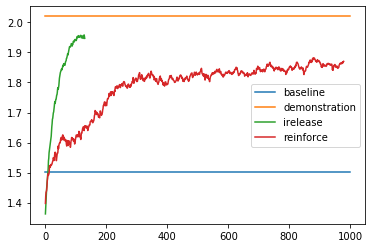

In [6]:
plt.plot(rl_baseline_mean_vals)
plt.plot(rl_biased_mean_vals)
plt.plot(nbu.smoothing_values(ppo_gen_mean_vals[:150])[20:])
plt.plot(nbu.smoothing_values(rl_gen_mean_vals)[20:])
plt.legend(['baseline','demonstration','irelease','reinforce'])

### Model analysis

In [7]:
generators = nbu.data_provider('../../data/logp_smiles_biased.smi', '../../data/unbiased_smiles.smi')

In [8]:
init_dict = nbu.initialize(nbu.logp_ppo_hparams(), generators['demo_data'], generators['unbiased_data'], True)

In [9]:
demo_data_gen = init_dict['demo_data_gen']
unbiased_data_gen = init_dict['unbiased_data_gen']

In [10]:
expert_model = init_dict['expert_model']

In [11]:
def sample_smiles(generator, num_samples):
    with torch.set_grad_enabled(False):
        gen_samples = []
        gen_logits = []
        hidden_neurons = []
        per_round = 200
        rounds = ceil(num_samples/per_round)
        if num_samples < 200:
            per_round = num_samples
        for i in range(rounds):
            smiles, logits, hidden = generate_smiles(generator, demo_data_gen, init_dict['gen_args'], 
                                                             num_samples=per_round, is_train=False, verbose=True, 
                                                             return_logits=True)
            gen_samples.extend(smiles)
            gen_logits.extend(logits)
            hidden_neurons.append(hidden)
    return gen_samples, np.array(gen_logits), np.concatenate(hidden_neurons, axis=1)

In [12]:
def plot_hist(prediction, num_generated):
    if isinstance(prediction, (list, tuple, set)):
        prediction = np.array(prediction)
    print("Mean value of predictions:", prediction.mean())
    print("Proportion of valid SMILES:", len(prediction)/num_generated)
    ax = sns.kdeplot(prediction.ravel(), shade=True)
    ax.set(xlabel='Predicted pIC50', 
           title='Distribution of predicted pIC50 for generated molecules')
    plt.show()

In [13]:
n_to_generate = 10

In [14]:
unbiased_smiles = unbiased_data_gen.random_training_set_smiles(n_to_generate)
unbiased_smiles_predictions = expert_model(unbiased_smiles)[1]
len(unbiased_smiles), unbiased_smiles[0]

(10, 'Cc1c(NC(=O)CCCn2cnc(-c3ccccn3)n2)cccc1C(F)(F)F')

In [15]:
biased_smiles = demo_data_gen.random_training_set_smiles(n_to_generate)
biased_smiles_predictions = expert_model(biased_smiles)[1]
len(biased_smiles), biased_smiles[0]

(10, 'Cc1ccccc1Nc1ncccc1Nc1ccccc1Nc1ccccc1')

### PPO models

In [16]:
ppo_agent_net = init_dict['agent_net']
ppo_agent_net.load_state_dict(nbu.load_model_weights('../model_dir/logp_irelease_stack-rnn_gru_ppo_agent_2020_06_25__01_31_53_1.978_500.mod'))
ppo_critic_net = init_dict['critic_net']
ppo_critic_net.load_state_dict(nbu.load_model_weights('../model_dir/logp_irelease_stack-rnn_gru_ppo_critic_2020_06_25__01_31_53_1.978_500.mod'))
ppo_reward_net = init_dict['reward_net']
ppo_reward_net.load_state_dict(nbu.load_model_weights('../model_dir/logp_irelease_stack-rnn_gru_ppo_reward_net_2020_06_25__01_31_53_1.978_500.mod'))

<All keys matched successfully>

In [17]:
ppo_samples, ppo_samples_logits, ppo_samples_neurons = sample_smiles(ppo_agent_net, n_to_generate)
print(len(ppo_samples))

Processing SMILES...: 100%|█████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10015.05it/s]


10


In [19]:
ppo_samples_neurons.shape

(99, 10, 1500)

In [ ]:
ppo_mols, ppo_samples_predictions, ppo_invalid = expert_model(ppo_samples)
len(ppo_samples_predictions), len(ppo_invalid)

In [ ]:
plot_hist(ppo_samples_predictions, len(ppo_samples))

### REINFORCE models

In [ ]:
init_dict = nbu.initialize(nbu.logp_reinforce_hparams(), generators['demo_data'], generators['unbiased_data'], False)
rl_agent_net = init_dict['agent_net']
rl_agent_net.load_state_dict(nbu.load_model_weights('../model_dir/logp_irelease_stack-rnn_gru_reinforce_agent_2020_06_25__01_56_50_1.873_600.mod'))
rl_reward_net = init_dict['reward_net']
rl_reward_net.load_state_dict(nbu.load_model_weights('../model_dir/logp_irelease_stack-rnn_gru_reinforce_reward_net_2020_06_25__01_56_50_1.873_600.mod'))

In [ ]:
rl_samples, rl_samples_logits, rl_samples_neurons = sample_smiles(rl_agent_net, n_to_generate)
print(len(rl_samples))

In [ ]:
rl_mols, rl_samples_predictions, rl_invalid = expert_model(rl_samples)
len(rl_samples_predictions), len(rl_invalid)

In [ ]:
plot_hist(rl_samples_predictions, len(rl_samples))

## Comparisons

### KDE plots

In [ ]:
sns.kdeplot(ppo_samples_predictions.ravel(),label='Optimized_irl', shade=True, color='red')
sns.kdeplot(rl_samples_predictions.ravel(),label='Optimized_rl', shade=True, color='blue')
sns.kdeplot(unbiased_smiles_predictions.ravel(), label='Unbiased', shade=True, color='grey')
ax = sns.kdeplot(biased_smiles_predictions.ravel(), label='Demo', shade=True, color='orange')
plt.xlabel('pIC50 values')
# ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_xticks([])
sns.despine(offset=5, left=True, bottom=False)
plt.show()

### RNN hidden neurons analysis

In [ ]:
def plot_heatmap(smiles_list, logits, neuron=None):
    if neuron is None:
        neuron = np.random.randint(logits.shape[-1])
    print(f'Plotting for neuron {neuron}')
    for i, smiles in enumerate(smiles_list):
#         print(smiles)
        arr = logits[:len(smiles), i, neuron].reshape(1, len(smiles))
        chars = np.array([c for c in smiles]).reshape(1,-1)
        fig = plt.figure(figsize=(200,4))
        sns.heatmap(arr, annot=chars, fmt='', cbar=False, 
                    cmap=sns.color_palette("bwr", 10), annot_kws={'size':100, 'fontweight':'normal'},
                   xticklabels=False, yticklabels=False, square=True)
        plt.show()

In [ ]:
ppo_samples_neurons.shape

In [ ]:
ppo_samples_neurons = np.squeeze(ppo_samples_neurons, 0)
ppo_samples_neurons.shape

In [ ]:
plot_heatmap(ppo_samples[:10], ppo_samples_neurons[:,:10,:])

In [ ]:
ppo_eval_rpt = nbu.evaluate(ppo_samples, biased_smiles)
ppo_eval_rpt

In [ ]:
rl_eval_rpt = nbu.evaluate(rl_samples, biased_smiles)
rl_eval_rpt

### Draw random compounds

In [ ]:
import os
import rdkit.Chem as Chem
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

In [ ]:
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in set(ppo_samples)]
sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]

In [ ]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['pIC50 = ' + str(round(float(ppo_samples_predictions[i]), 3)) for i in ind]
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(300,300), legends=legends)

In [ ]:
# Save selected compounds to file
# os.makedirs('./logp_samples', exist_ok=True)
# for i, mol in enumerate(mols_to_draw):
#     Draw.MolToImageFile(mol, f'./logp_samples/pic50_{round(float(ppo_samples_predictions[i]), 3)}.png')

## Reward net analysis

In [ ]:
ppo_samples = [s.strip() for s in ppo_samples]
ppo_invalid_smiles = [s.strip() for s in ppo_invalid]
len(ppo_samples)

In [ ]:
encoder = init_dict['encoder']
ppo_reward_net_rnn = init_dict['reward_net_rnn']

In [ ]:
with torch.set_grad_enabled(False):
    inp, valid_vec = nbu.smiles_to_tensor(ppo_invalid_smiles)
    enc_out = encoder([inp, valid_vec])
    reward, logits = ppo_reward_net_rnn(enc_out, return_logits=True)

In [ ]:
logits.shape

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd 

In [ ]:
tsne_rep = TSNE(n_components=2).fit_transform(logits.detach().cpu().numpy())
data = pd.DataFrame({'dim_1':tsne_rep[:,0], 'dim_2':tsne_rep[:,1]})

In [ ]:
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(tsne_rep[:, 0], tsne_rep[:, 1], c=tsne_rep[:, 1], vmin=0, vmax=20, s=35, cmap=cm)
plt.colorbar(sc)
plt.axis('off')
plt.show()

In [ ]:
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(tsne_rep[:, 0], tsne_rep[:, 1], c=tsne_rep[:, 1], vmin=0, vmax=20, s=35, cmap=cm)
plt.colorbar(sc)
plt.axis('off')
plt.show()